# Aim

<div style = "text-align: justify">The aim of this dataset is to classify the type white blood cells in the image namely, <b>EOSINOPHIL, LYMPHOCYTE, MONOCYTE and NEUTROPHIL.</b></div>

### Dataset - [Link](https://www.kaggle.com/paultimothymooney/blood-cells)

### Structure
<div style = "text-align: justify">The dataset contains 12,500 augmented images (JPEG format). The <b>images</b> folder will have three subfolders - <b>TEST, TEST_SIMPLE and TRAIN.</b> Each of these subfolders is further divided into - <b>EOSINOPHIL, LYMPHOCYTE, MONOCYTE and NEUTROPHIL.</b></div>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL.Image import fromarray

(-0.5, 982.5, 351.5, -0.5)

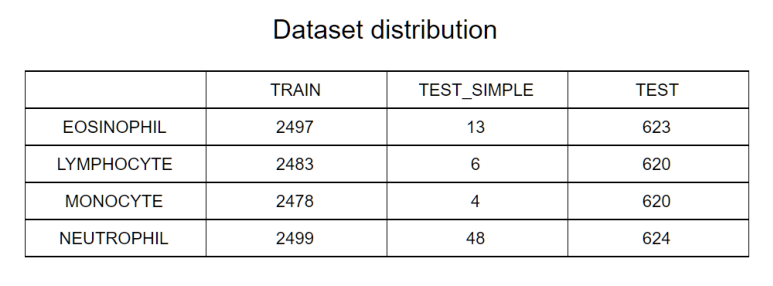

In [2]:
img = cv2.imread('../input/data-dist/Capture.PNG')
plt.figure(figsize = (20,5))
plt.imshow(img)
plt.axis('off')

In [3]:
from keras.preprocessing.image import img_to_array

In [4]:
wbcs = [
    'LYMPHOCYTE',  # 0
    'MONOCYTE'  ,  # 1
    'NEUTROPHIL',  # 2
    'EOSINOPHIL',  # 3
]

In [5]:
def mask (path) :
    
    x = cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), (128,128))
    m = np.ones(x.shape)*255.0
    
    m[(x[:,:,0] >= 160) & (x[:,:,1] >= 140) & (x[:,:,2] >= 140)] = [0.0,0.0,0.0]
    
    kernel = np.ones((3,3), dtype = np.uint8)
    m = cv2.dilate(m, kernel, iterations = 2)
    
    return cv2.bitwise_and(x, np.array(m, np.uint8))

In [6]:
def get_images (path) :
    
    X = []
    y = []
    
    for n, wbc_type in enumerate(wbcs) :
        
        for image_path in os.listdir(os.path.join(path, wbc_type)) :
            p=os.path.join(os.path.join(path,wbc_type),image_path)
            X.append(img_to_array(fromarray(mask(p))))
            y.append(n)
    return  np.array(X), np.array(y)

In [7]:
path = '../input/blood-cells/dataset2-master/dataset2-master/images/'

In [8]:
X_valid, y_valid = get_images(path + 'TEST_SIMPLE')
X_train, y_train = get_images(path + 'TRAIN')
X_test , y_test  = get_images(path + 'TEST' )

In [9]:
from keras.utils import to_categorical

In [10]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test  = to_categorical(y_test )

# Dataset Overview

In [11]:
print(X_train.shape)
print(y_train.shape)

(9957, 128, 128, 3)
(9957, 4)


In [12]:
print(X_valid.shape)
print(y_valid.shape)

(71, 128, 128, 3)
(71, 4)


In [13]:
import seaborn
import pandas

Text(0.5, 1.0, 'Testing set distribution...')

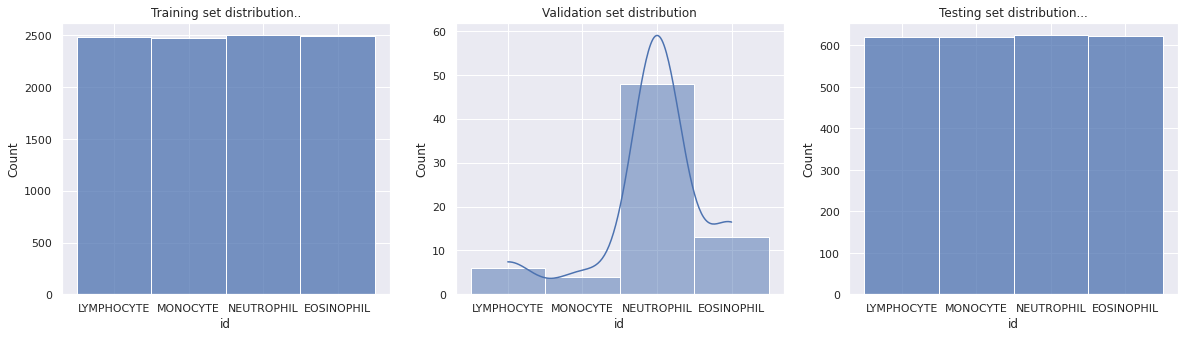

In [14]:
plt.figure(figsize = (20,5))

seaborn.set_theme(style = 'darkgrid')

plt.subplot(1,3,1)
seaborn.histplot(pandas.DataFrame({'id' : [wbcs[x] for x in np.argmax(y_train, axis = 1)]}),
                 x = 'id')
plt.title('Training set distribution..')

plt.subplot(1,3,2)
seaborn.histplot(pandas.DataFrame({'id' : [wbcs[x] for x in np.argmax(y_valid, axis = 1)]}),
                 x = 'id', kde = True)
plt.title('Validation set distribution')

plt.subplot(1,3,3)
seaborn.histplot(pandas.DataFrame({'id' : [wbcs[x] for x in np.argmax(y_test , axis = 1)]}),
                 x = 'id')
plt.title('Testing set distribution...')

# Visualizations

In [15]:
X_train /= 255.0
X_valid /= 255.0
X_test  /= 255.0

**TRAINING IMAGES**

In [16]:
from numpy.random import randint

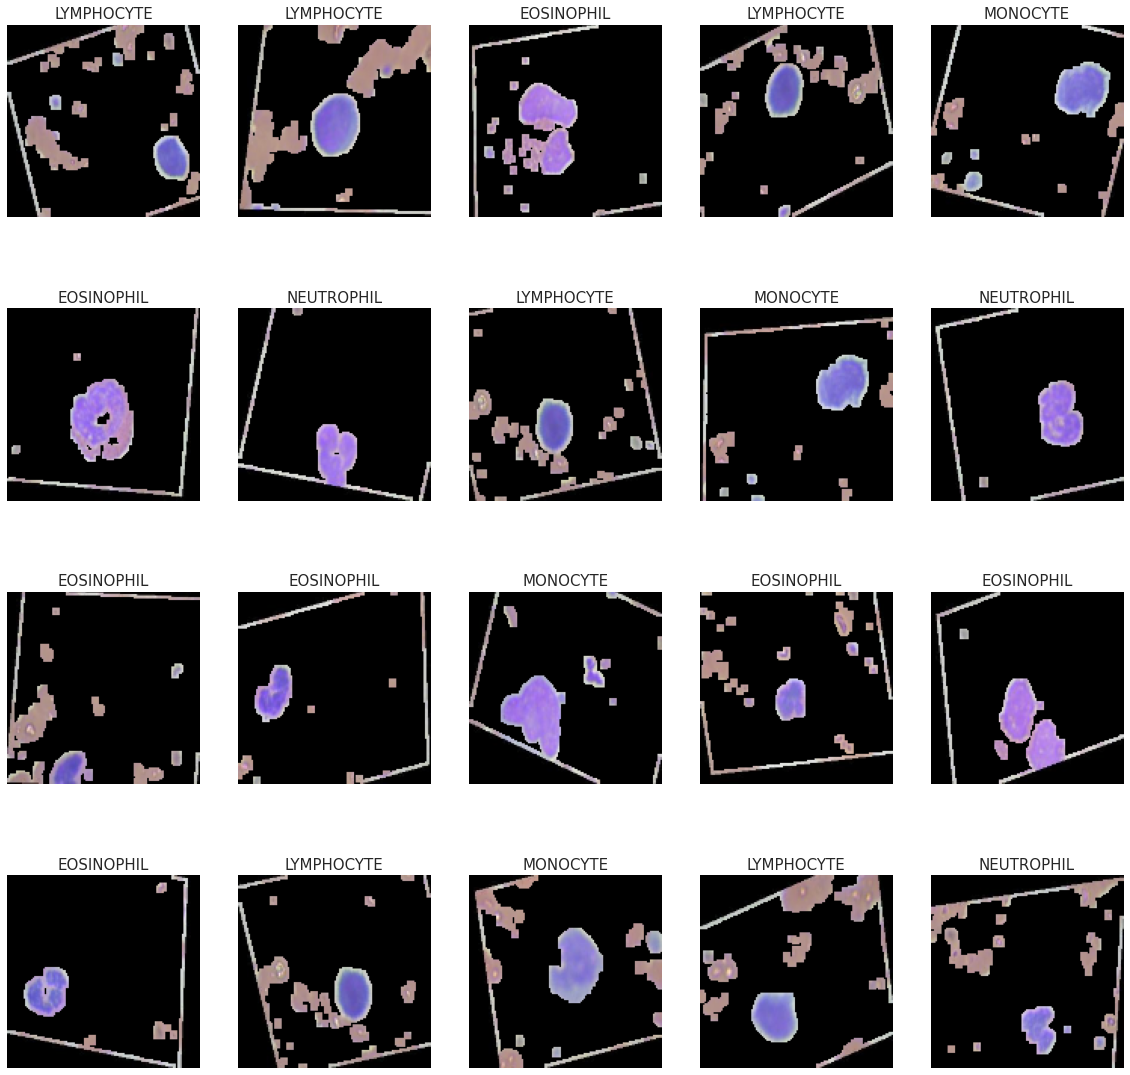

In [17]:
plt.figure(figsize = (20,20))

i = 0
LIMIT = 9957

while i < 20 :
    
    plt.subplot(4,5,i+1)
    x = randint(0,LIMIT)
    plt.imshow(X_train[x])
    plt.title(wbcs[np.argmax(y_train[x])], fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

**Validation Images**

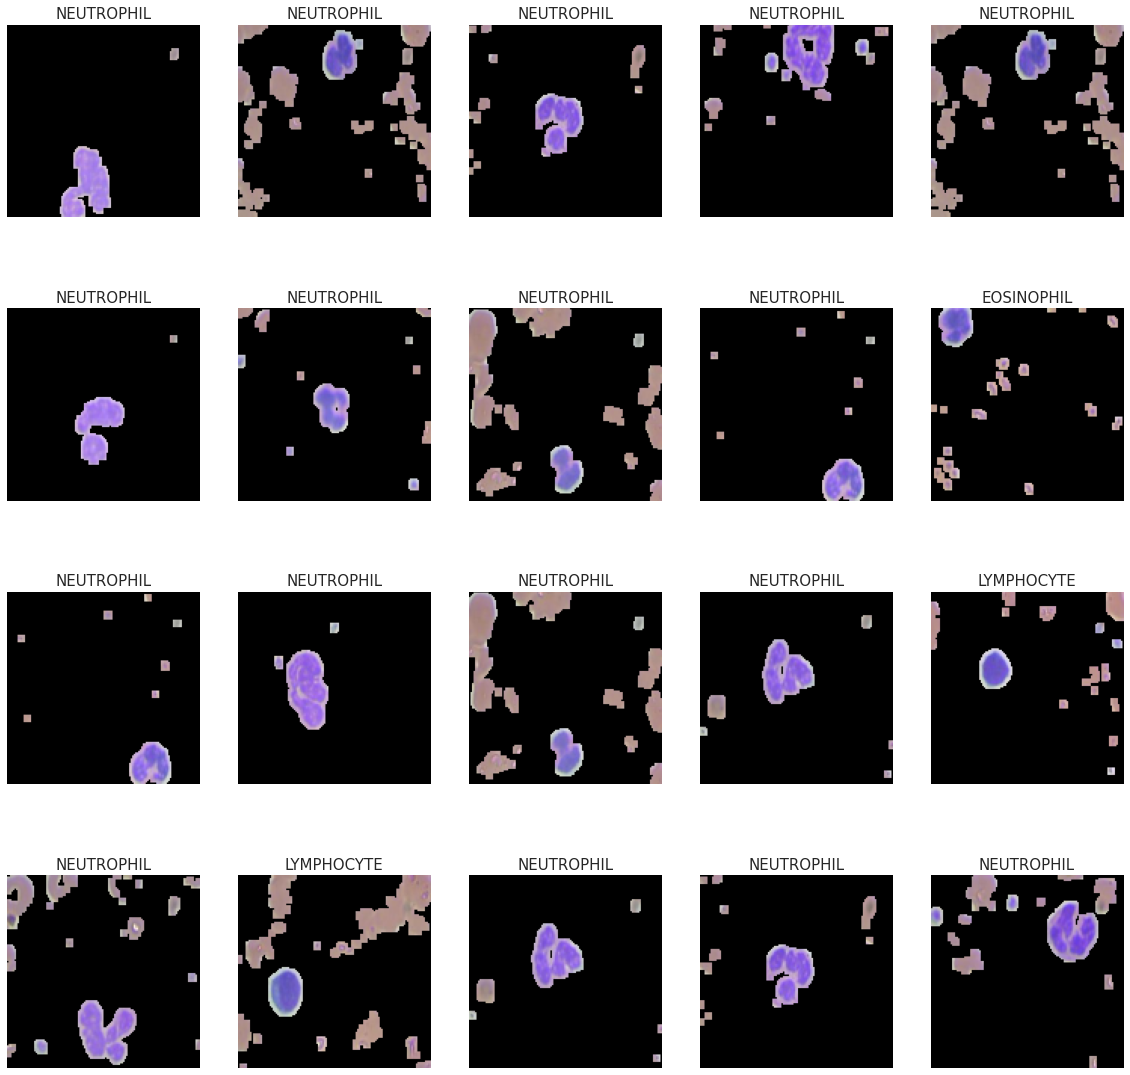

In [18]:
plt.figure(figsize = (20,20))

i = 0
LIMIT = 71

while i < 20 :
    
    plt.subplot(4,5,i+1)
    x = randint(0,LIMIT)
    plt.imshow(X_valid[x])
    plt.title(wbcs[np.argmax(y_valid[x])], fontsize = 15)
    plt.axis('off')
    
    i += 1
plt.show()

# Model

In [19]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

In [20]:
'''
Conv - BatchNorm -
LeakyReLU - MaxPool
'''

def conv_layer (filters) :
    
    model = Sequential()
    
    model.add(Conv2D(filters,
                     (3,3),
                     strides = 1,
                     padding = 'same',
                     kernel_regularizer = 'l2'))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2, 2)))
    
    return model

'''
Dense - BatchNorm -
Dropout - LeakyReLU
'''

def dens_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx,
                    kernel_regularizer = 'l2'))
    
    model.add(BatchNormalization())
    model.add(Dropout(.4))
    model.add(LeakyReLU())
    
    return model

'''
Model
'''

def cnn (filter1,
         filter2,
         filter3,
         filter4,  hidden1) :
    
    model = Sequential([
        
        Input((128,128,3,)),
        conv_layer(filter1),
        conv_layer(filter2),
        conv_layer(filter3),
        conv_layer(filter4),
        Flatten(),
        dens_layer(hidden1),
        Dense(4, activation = 'softmax')
    ])
    
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001),
                  metrics = ['accuracy'])
    return model

In [21]:
model = cnn(32, 64, 128, 256, 64)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 32)        1024      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 64)        18752     
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 16, 128)       74368     
_________________________________________________________________
sequential_3 (Sequential)    (None, 8, 8, 256)         296192    
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 64)                1048896   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                

# fit()

In [22]:
from keras.callbacks import ModelCheckpoint
checkp = ModelCheckpoint('./model.h5', monitor = 'val_loss', save_best_only=True,verbose=1)

In [23]:
history = model.fit(X_train, y_train, batch_size = 32, validation_data = (X_valid, y_valid),
                    callbacks = [checkp], epochs = 150)

Epoch 1/150
312/312 [==============================] - 11s 20ms/step - loss: 5.8502 - accuracy: 0.3568 - val_loss: 8.2756 - val_accuracy: 0.0563

Epoch 00001: val_loss improved from inf to 8.27555, saving model to ./model.h5
Epoch 2/150
312/312 [==============================] - 5s 18ms/step - loss: 4.6751 - accuracy: 0.6405 - val_loss: 5.7469 - val_accuracy: 0.1408

Epoch 00002: val_loss improved from 8.27555 to 5.74692, saving model to ./model.h5
Epoch 3/150
312/312 [==============================] - 5s 17ms/step - loss: 3.9827 - accuracy: 0.7365 - val_loss: 4.2841 - val_accuracy: 0.5352

Epoch 00003: val_loss improved from 5.74692 to 4.28414, saving model to ./model.h5
Epoch 4/150
312/312 [==============================] - 5s 17ms/step - loss: 3.3758 - accuracy: 0.8157 - val_loss: 3.4756 - val_accuracy: 0.6761

Epoch 00004: val_loss improved from 4.28414 to 3.47563, saving model to ./model.h5
Epoch 5/150
312/312 [==============================] - 5s 17ms/step - loss: 2.9130 - accura

### Plot the accuracy and loss

Text(0, 0.5, 'Accuracy')

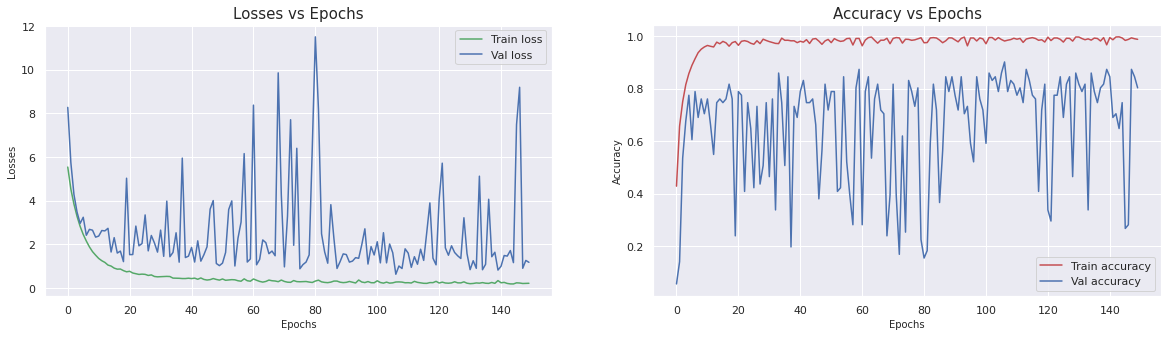

In [24]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'])
plt.legend(['Train loss','Val loss'])         # Plot loss for train
plt.title('Losses vs Epochs', fontsize = 15)  # valid data. Test
plt.xlabel('Epochs', fontsize = 10)           # data not included!!
plt.ylabel('Losses', fontsize = 10)


plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],     'r')
plt.plot(history.history['val_accuracy'], 'b')

plt.legend(['Train accuracy', 'Val accuracy'])# Plot the accuracy
plt.title('Accuracy vs Epochs', fontsize = 15)# for train and val
plt.xlabel('Epochs'  , fontsize = 10)         # dataset.
plt.ylabel('Accuracy', fontsize = 10)

In [25]:
from keras.models import load_model

In [26]:
model = load_model('./model.h5')

# Predictions

# Predictions on validation data

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [28]:
y_pred = model.predict(X_valid)

In [29]:
y_pred  = np.argmax(y_pred , axis = 1)
y_valid = np.argmax(y_valid, axis = 1)

In [30]:
print('Accuracy for validation data : ' + str(accuracy_score(y_valid, y_pred)))
print(classification_report(y_valid, y_pred, target_names = wbcs))

Accuracy for validation data : 0.9014084507042254
              precision    recall  f1-score   support

  LYMPHOCYTE       1.00      1.00      1.00         6
    MONOCYTE       0.43      0.75      0.55         4
  NEUTROPHIL       0.98      0.94      0.96        48
  EOSINOPHIL       0.83      0.77      0.80        13

    accuracy                           0.90        71
   macro avg       0.81      0.86      0.83        71
weighted avg       0.92      0.90      0.91        71



In [31]:
cm = confusion_matrix(y_valid, y_pred)

Text(0.5, 142.81999999999996, 'Predicted')

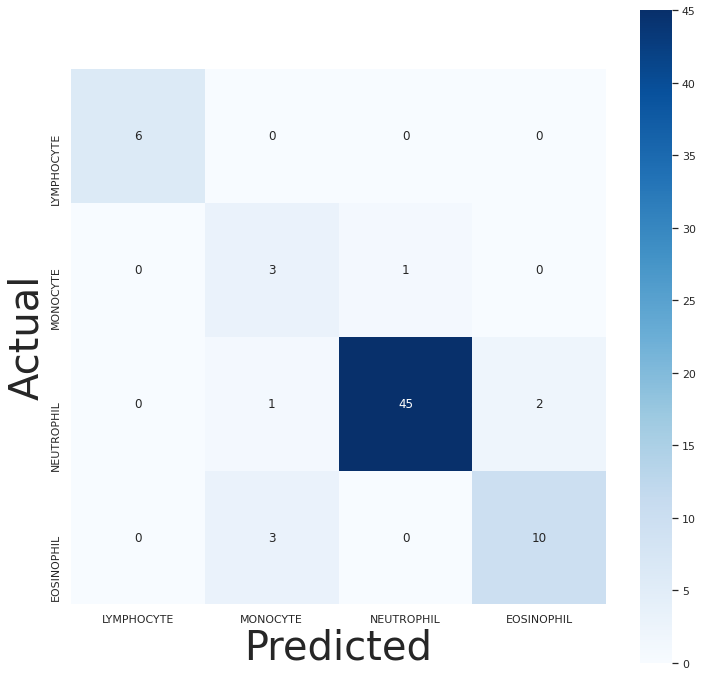

In [32]:
plt.figure(figsize = (12,12))

ax = seaborn.heatmap(cm, cmap = plt.cm.Blues, annot = True, square = True,
                     xticklabels = wbcs, yticklabels=wbcs)
ax.set_ylabel('Actual'   , fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)

# Predictions on testing data

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [35]:
print('Accuracy on the test set : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = wbcs))

Accuracy on the test set : 0.804583835946924
              precision    recall  f1-score   support

  LYMPHOCYTE       0.99      0.85      0.92       620
    MONOCYTE       0.80      0.75      0.77       620
  NEUTROPHIL       0.63      0.92      0.75       624
  EOSINOPHIL       0.93      0.70      0.80       623

    accuracy                           0.80      2487
   macro avg       0.84      0.80      0.81      2487
weighted avg       0.84      0.80      0.81      2487



In [36]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 142.81999999999996, 'Predicted')

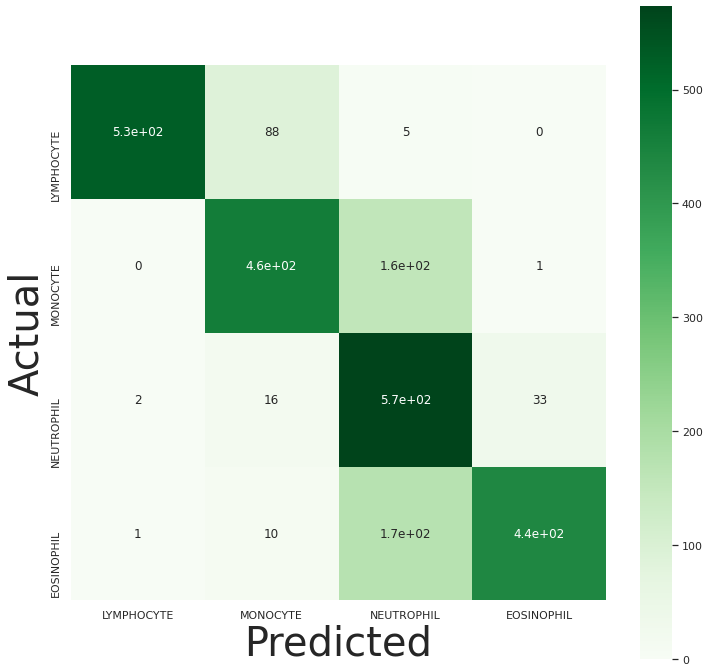

In [37]:
plt.figure(figsize = (12,12))

ax = seaborn.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True,
                     xticklabels = wbcs, yticklabels=wbcs)
ax.set_ylabel('Actual'   , fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)